In [1]:
import numpy as np
import gym
import os
import random
import time
from progressbar import ProgressBar
from time import sleep
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import scipy
from matplotlib import image
from progressbar import ProgressBar

from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten
from keras import optimizers
from keras import backend as K

Using TensorFlow backend.


In [2]:
def create_network(action_size, alpha, initializer='glorot_uniform'):
    optimizer = optimizers.RMSprop(lr=alpha)
    
    net = Sequential([
        Conv2D(
            32,
            (8, 8),
            strides=(4,4),
            input_shape=(84, 84, 4),
            activation='relu',
            kernel_initializer=initializer,
            data_format="channels_last"
        ),
        Conv2D(
            64,
            (4,4),
            strides=(2,2),
            activation='relu',
            kernel_initializer=initializer
        ),
        Conv2D(
            64,
            (3,3),
            strides=(1,1),
            activation='relu',
            kernel_initializer=initializer
        ),
        Flatten(),
        Dense(512, activation='relu', kernel_initializer=initializer),
        Dense(action_size, activation='linear', kernel_initializer=initializer)
    ])
    net.compile(loss='mse', optimizer=optimizer)
    return net

In [3]:
def pre_process_frame(frame, prev_frame):
    r = frame[:,:,0] # red channel
    g = frame[:,:,1] # blue channel
    b = frame[:,:,2] # green channel
    l = (0.2126*r + 0.7152*g + 0.0722*b) # luminescence 
    max_r = max(np.max(prev_frame[:,:,0]), np.max(r))
    max_g = max(np.max(prev_frame[:,:,1]), np.max(g))
    max_b = max(np.max(prev_frame[:,:,2]), np.max(b))
    
    
    normalized_color = np.zeros((frame.shape[0], frame.shape[1], 4))
    normalized_color[:,:,0] = r.astype(np.float64) / max_r
    normalized_color[:,:,1] = g.astype(np.float64) / max_g
    normalized_color[:,:,2] = b.astype(np.float64) / max_b
    normalized_color[:,:,3] = l
    
    
    phi_frame = np.zeros((84, 84, 4))
    zoom_shape = np.array(phi_frame.shape, dtype=float) / np.array(normalized_color.shape, dtype=float)
    phi_frame = scipy.ndimage.zoom(normalized_color, zoom_shape)
    return phi_frame


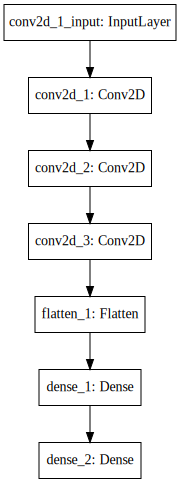

In [4]:
alpha = 0.00025
gamma=0.99
epochs=5000
action_update_interval = 4
q_update_interval = 16
qhat_update_interval = 500
sample_size=32 # how many samples do we take each time
min_replay_size = 500 # whhen does training start (replay mem size)
max_replay_size = 25000 # what is the max replay memory
chart_interval = 1000

# step increment at begining of loop
step = -1

# trainy boi
training_started = False
frame_memory = np.zeros((max_replay_size, 84, 84, 4), dtype='float')
prime_frame_memory = np.zeros((max_replay_size, 84, 84, 4), dtype='float')
action_memory = np.zeros((max_replay_size, 1), dtype='int')
reward_memory = np.zeros((max_replay_size, 1), dtype='float')
done_memory = np.zeros((max_replay_size, 1), dtype='bool')

replay_index = -1

# stats
training_rewards = []
rewards = []
mean_rewards = []
mean_training_rewards = []
epsilons = []

# init env
env_name = 'VideoPinball-v0'
env = gym.make(env_name)
state_size = env.observation_space.shape[0]
action_size = env.env.action_space.n

# init networks
q_net = create_network(action_size, alpha)
q_hat_net = create_network(action_size, alpha, 'zeros')

pbar = ProgressBar()
training_score = []
test_score = []
last_episode = 0

SVG(model_to_dot(q_net).create(prog='dot', format='svg'))

In [ ]:

def time_usage(func):
    def wrapper(*args, **kwargs):
        beg_ts = time.time()
        retval = func(*args, **kwargs)
        end_ts = time.time()
        # print("elapsed time %s: %f" % (func.__name__, end_ts - beg_ts))
        return retval
    return wrapper

def run_episode(epsilon, pool_actions=False, render=True):
    # print("Start Episode: epsilon %s", epsilon)
    moves = 0
    beg_ts = time.time()
    done = False
    frame = env.reset()
    prev_frame = np.zeros_like(frame) # the "prevvious" frame is nothing
    phi_frame = pre_process_frame(frame, prev_frame)

    while not done and moves < 1000:
        if np.random.rand() < epsilon:
            action = np.random.randint(action_size)
        else:
            phi_shape = phi_frame.shape
            shaped_frame = phi_frame.reshape(1, phi_shape[0], phi_shape[1], phi_shape[2])
            action = np.argmax(q_net.predict(shaped_frame))

        prime_frame, reward, done, ale_lives = env.step(action)
        phi_prime_frame = pre_process_frame(frame, prime_frame)
        lives = ale_lives['ale.lives']
        done = done or lives == 0

        if render:
            env.render()
            sleep(0.0001)

        yield phi_frame, action, reward, phi_prime_frame, done, lives

        phi_frame = phi_prime_frame
        prev_frame = frame
        frame = prime_frame
        moves += 1

    end_ts = time.time()
    # print("elapsed time run_episode: %s moves %fs" % (moves, end_ts - beg_ts))

weight_updates = 0

# @time_usage
def update_weights():
    # crop memory
    global frame_memory, action_memory, reward_memory, prime_frame_memory, done_memory, weight_updates, replay_index

    memory_sample = random.sample(
        range(0, min(replay_index, max_replay_size)),
        sample_size
    )

    _frame_batch = frame_memory[memory_sample]
    _prime_frame_batch = prime_frame_memory[memory_sample]
    _action_batch = action_memory[memory_sample]
    _reward_batch = reward_memory[memory_sample]
    _done_batch = done_memory[memory_sample]

    _predictions = q_net.predict(_frame_batch)
    _corrections = _predictions.copy()
    _prime_predictions = q_hat_net.predict(_prime_frame_batch)

    for i in range(0, sample_size):
        _done = _done_batch[i]
        _reward = _reward_batch[i]
        _action = _action_batch[i]

        _prime_prediction = _prime_predictions[i]
        if _done:
            _corrections[i, _action] = _reward_batch[i]
        else:
            _corrections[i, _action] = _reward + gamma * np.max(_prime_prediction)
    q_net.train_on_batch(_frame_batch, _corrections)


    if weight_updates % qhat_update_interval == 0:
        # print("updating target")
        q_hat_net.set_weights(q_net.get_weights())
    weight_updates += 1

step = -1
training_started = False

# for episode in pbar(range(last_episode, epochs)):
if True:
    last_episode = episode
    
    if episode < epochs / 10:
        epsilon = 0.99
    elif episode < epochs / 4:
        epsilon = 0.75
    elif episode < epochs / 2:
        epsilon = 0.50
    elif episode < 3 * epochs / 4:
        epsilon = 0.25
    else:
        epsilon = 0.01

    training_score = 0

    # for every action in the episode
    for (
        frame,
        action,
        reward,
        prime_frame,
        done,
        lives
    ) in run_episode(.99, pool_actions=True, render=True):
        step += 1
        #
        replay_index += 1
        replay_array_index = replay_index % max_replay_size
        frame_memory[replay_array_index] = frame
        prime_frame_memory[replay_array_index] = prime_frame
        action_memory[replay_array_index] = action
        reward_memory[replay_array_index] = reward
        done_memory[replay_array_index] = done

        training_score += reward

        # if time do the training
        if step % q_update_interval == 0 and min_replay_size < replay_index:
            if not training_started:
                training_started = True
                # print("Training Started: ", step)
            update_weights()


# #     test the net
#     test_score = 0

#     for (
#         prev_frame,
#         action,
#         reward,
#         frame,
#         done,
#         lives
#     ) in run_episode(0.01, pool_actions=False, render=True):
#         test_score += test_score

    # print("Record metrics")
    training_rewards.append(training_score)
#     rewards.append(test_score)
#     mean_rewards.append(np.mean(rewards[-100:]))
    mean_training_rewards.append(np.mean(training_rewards[-100:]))
    epsilons.append(epsilon)

    # display progress
    if True: #(episode + 1) % chart_interval == 0:
        index_step = 10
        episodes_num = np.arange(0, len(mean_training_rewards))[0::index_step]
        _mean_training_rewards = mean_training_rewards[0::index_step]
#         _mean_rewards = mean_rewards[0::index_step]
#         _rewards = rewards[0::index_step]
        _training_rewards = training_rewards[0::index_step]
        _epsilons = epsilons[0::index_step]
        episode_index = len(mean_training_rewards)

        fig = plt.figure(figsize=(8, 5), dpi=100)
        par1 = fig.subplots()
        par2 = par1.twinx()

        par2.plot(episodes_num, _epsilons, marker='o', markersize=5, label='Epsilon', color='purple')
        par2.set_ylim(-0.1, 1.1)
        par2.legend(loc='lower right')

        par1.plot(episodes_num, _training_rewards, marker='o', markersize=5, label='Training Reward')
#         par1.plot(episodes_num, _rewards, marker='o', markersize=5, label='Test Reward')
        par1.plot(episodes_num, _mean_training_rewards, marker='x', markersize=5, label='Mean Training Rewards')
#         par1.plot(episodes_num, _mean_rewards, marker='o', markersize=5, label='Mean Test Reward')
        par1.legend(loc='lower left')
        par1.set_xlabel('epoch')
        par1.set_ylabel('Mean Reward')
        plt.pause(0.01)

        # save after charting
        model_file = '%s-%s-%s.weights' % (env_name, alpha, episode)
        q_net.save_weights(model_file)
        
       

In [ ]:
model_file = '%s-%s-%s.weights' % (env_name, alpha, episode)
net.save_weights(model_file)
print(model_file)

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(q_net).create(prog="dot", format="svg"))